In [3]:
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import io
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt

from numpy import ndarray
import torch.optim as optim
from tqdm import tqdm
import random
from PIL import Image
import glob, os


import SimpleITK as sitk
from skimage.transform import rotate, AffineTransform, warp

from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


In [26]:
t1a = np.load('/media/yu-hao/WindowsData/dival/dival/examples/p1.npy')
t2a = np.load('/media/yu-hao/WindowsData/dival/dival/examples/p2.npy')

print(t1a.shape, t2a.shape)

(5, 1000, 513) (5, 362, 362)


(array([5.12949e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.10000e+01]),
 array([0.        , 0.00368214, 0.00736427, 0.0110464 , 0.01472854,
        0.01841068, 0.02209281, 0.02577494, 0.02945708, 0.03313921,
        0.03682135], dtype=float32),
 <a list of 10 Patch objects>)

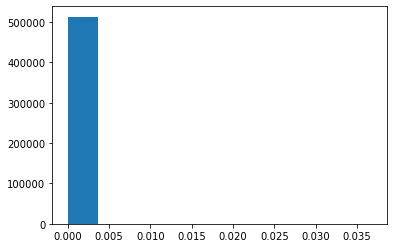

In [25]:
#d = np.abs(t1-t1a)
#plt.hist(d.flatten())

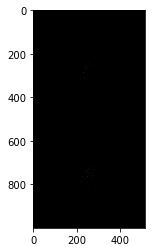

In [22]:
plt.imshow(t1a[0], cmap='gray')

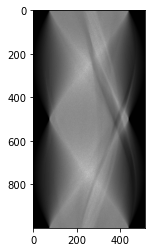

In [18]:
plt.imshow(t1, cmap='gray')

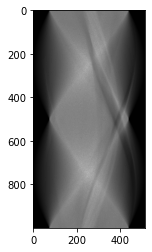

In [16]:
plt.imshow(t1, cmap='gray')
#plt.hist(t1.flatten())

In [1]:
def train_model_attn(model, optimizer,model2 ,criterion, trainx, trainy, augment=False):
    batch_size = 1
    loss_array = []
   
    model.train()
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
    
        x = np.expand_dims(x, 1)
            

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
        optimizer.zero_grad()
        
        
        output,encodings,x4,x3,x2,x1 = model2.forward(x)
        #print(encodings.shape)
        
        ou = model.forward(encodings,x4,x3,x2,x1)
        #print(i,attn_weights[1])
        
        loss   = criterion(ou , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
        torch.nn.utils.clip_grad_norm_(attn_decoder1.parameters(),0.1)
        
        optimizer.step()
        
    loss_array = np.mean(loss_array)
    return loss_array

In [1]:
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import io
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt

from numpy import ndarray
import torch.optim as optim
from tqdm import tqdm
import random
from PIL import Image
import glob, os

import torch


import torchvision.transforms as transforms


import SimpleITK as sitk
from skimage.transform import rotate, AffineTransform, warp

from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up2(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x):
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
   


class UNetmini(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetmini, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits


In [2]:
class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        
        self.down5 = Down(128,256)
        
        self.down6 =Down(256,512)
        
        self.down7 =Down(512,1024)
        
        self.down8 =Down(1024,2048)
        
        self.down9 =Down(2048,4096)
        

        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
       
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([1,256,256])
        
        #xlst = torch.unsqueeze(xlst,1)
 
        #hidden = self.hidden_value
        #hidden = (torch.randn(1,128,1024).cuda(),torch.randn(1,128,1024).cuda())
        
        hidden = (nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda()))
        #print(epoch,hidden)
        
        #hidden = hidden.cuda()
        
        lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=2).cuda()
        
    
#         print(xlst.shape)
        
#         print('hidden before',len(hidden))
        
        
        
        ylst,hidden = lstm(xlst,hidden)
        
        
#         #print(ylst,hidden[0])
        
        h  = torch.cuda.FloatTensor(hidden[0])
        h = torch.squeeze(h)
        
        
        
#         print('h, ylst, xlst')
#         print(h.shape)
#         print(ylst.shape)
#         print(xlst.shape)
                
        
        oo,b,c = attn_decoder1.forward(xlst,hidden,ylst)
        
        #print("geeekk",oo.shape)
        
        
        oo = oo.reshape([1,256,16,16])
        
        
        x5 = oo   

        
        #print(x5.shape)
        
#         upsample = torch.nn.ConvTranspose2d(4096, 2048, 2, stride=2, padding=1)
        
     
        
        ups3 = nn.ConvTranspose2d(512 , 512 // 2, kernel_size=2, stride=2)
        upsconv3 = DoubleConv(512,256)

        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        ups3 = ups3.cuda()
    
        
        
       # opt = ups3(x5)
        
        opt = ups4(x5)
        
    
    
        #print('the lasttttttt: ',opt.shape)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        x = self.gn5(x)
        
        
        
        #(batchsize,128,32,32)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
       
        x = self.up3(x, x2)
        x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

In [3]:
class UNetHalf(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetDoubleSmallGroupNorm, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
       
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
    
        
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
       
        x = self.up3(x, x2)
        x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return x5

In [4]:
def get_entropy_image(vols_array):
    entropy_images = np.zeros([5, vols_array[0].shape[0], vols_array[0].shape[1], vols_array[0].shape[2]])
   
    for i in range(vols_array[0].shape[0]):
        a = []
        for k in range(5):
            a.append(vols_array[k][i])
       
        con  = np.sum(a, axis=0)/5
        temp = con.flatten()
        con  = np.array([temp, 1-temp]).T
       
        for k in range(5):
            r1  = vols_array[k][i].flatten()
            a11 = np.array([r1, 1-r1]).T
            e1 = entropy(a11, qk=con, axis=1)
            e1 = np.reshape(e1, [512, 512])
            entropy_images[k, i, :, :] = e1
       
    return entropy_images

def get_entropy_reduced_image(vols_array, entropy_image):
    axis     = 0
    idx      = list(np.ogrid[[slice(vols_array.shape[ax]) for ax in range(vols_array.ndim) if ax != axis]])
    argmaxes = np.argmax(entropy_image, axis)
    idx.insert(axis, argmaxes)
   
    result   = vols_array[idx]
    sumimage = np.sum(vols_array, 0)
   
    result   = sumimage - result
    result   = result/4.0
   
    return result

def read_training_data(read_ids):
    x_array = []
    y_array = []
   
    basepath  = '/home/ubuntu/Inf-Net/'

    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
       
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
       
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    #print(x_array,np.shape(x_array))
    x_array = (np.array(x_array)+1024.0)/1024.0

    print('x_array',np.shape(x_array))
    y_array = np.array(y_array)
    #print(y_array,np.shape(y_array))
   
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
   
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    basepath = '/home/ubuntu/Inf-Net/'
   
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
   
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
       
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
       
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
       
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
   
    return x_array, x_array_lungmask



def get_prediction(model, valx):
    output_array   = []
    batch_size     = 8
   
    model.eval()
    #print(len(valx)//batch_size)
   
    for ik in range(len(valx)//batch_size):
        
        #print((ik+1)*batch_size)
   
        
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output < 0.05]= 0
       
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
            
   
    valx = valx[0:(ik+1)*batch_size, :, :, :]
    #print(valx.shape)
    output_array = np.array(output_array)


    output_array = np.expand_dims(output_array, 1)
   
    return output_array,valx

def get_filtered(valx, valy):
    valxf = []
    valyf = []
   
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def get_entropy_reduced_prediction(model, weights, valx):
    vols_array = []
   
    for i in range(0, 5):
        model.load_state_dict(weights[i])
        result = get_prediction(model, valx)
        result = result[:, 0, :, :]
        vols_array.append(result)
   
    vols_array    = np.array(vols_array)
    entropy_image = get_entropy_image(vols_array)
    entropy_reduced_prediction = get_entropy_reduced_image(vols_array, entropy_image)
    entropy_reduced_prediction = np.expand_dims(entropy_reduced_prediction, 1)
    #return np.expand_dims(vols_array[0], axis=1)
    return entropy_reduced_prediction
def get_selected_lesion(valy, S, T):
    valy_new = np.zeros(valy.shape, dtype='uint8')
   
    for i in range(valy.shape[0]):
        blobs        = valy[i, 0]
        blobs_labels = measure.label(blobs, background=0)
        propsa       = measure.regionprops(blobs_labels)
       
        for k in range(len(propsa)):
            if propsa[k].area > S and propsa[k].area < T:
                continue
            else:
                blobs_labels[blobs_labels == propsa[k].label] = 0
       
        blobs_labels[blobs_labels > 0] = 1
        valy_new[i, 0] = blobs_labels
   
    return valy_new


def evaluate_result(model, valx, valy):
    model.eval()

    #print('123',len(valx))
   
    val_dice       = []
    batch_size     = 8
    for ik in range(len(valx)//batch_size):
        
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()
    
        
        

        output = model.forward(x)


        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()
     
        has_mask = y[0].max() > 0 

        #print(y[0])

        #print('mask value is ',has_mask)   

        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
            
    return val_dice

def evaluate_result_dec(model, model2,valx, valy):
    model.eval()

    #print('123',len(valx))
   
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()
    
        
        oo,x5,x4,x3,x2,x1 = model2.forward(x)

        output = model.forward(x5,x4,x3,x2,x1)
  


        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()
     
        has_mask = y[0].max() > 0 

        #print(y[0])

        #print('mask value is ',has_mask)   

        output[output < 0.5] = 0
        output[output > 0.5] = 1
       
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice




In [5]:
class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
       # print('x5:',x5.shape)
        
        xlst = x5.reshape([8,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        
        
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = ndarray((8,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(8):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([8,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
    
        

        
        opt = ups4(x5)
        
    
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        
       
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits



In [4]:
# Change name
import glob
import os
import matplotlib.pyplot as plt
a = glob.glob('/media/yu-hao/WindowsData/COVID-19-20_v2/Result/*')
for t in a:
    p = t.replace('volume-covid19-A-0', '').replace('_ct', '')
    os.rename(t, p)

/media/yu-hao/WindowsData/WalnutDataRecon/14_0.0143.npy
/media/yu-hao/WindowsData/WalnutDataRecon/14_0.0361.npy
/media/yu-hao/WindowsData/WalnutDataRecon/14_0.0381.npy
/media/yu-hao/WindowsData/WalnutDataRecon/14_0.npy


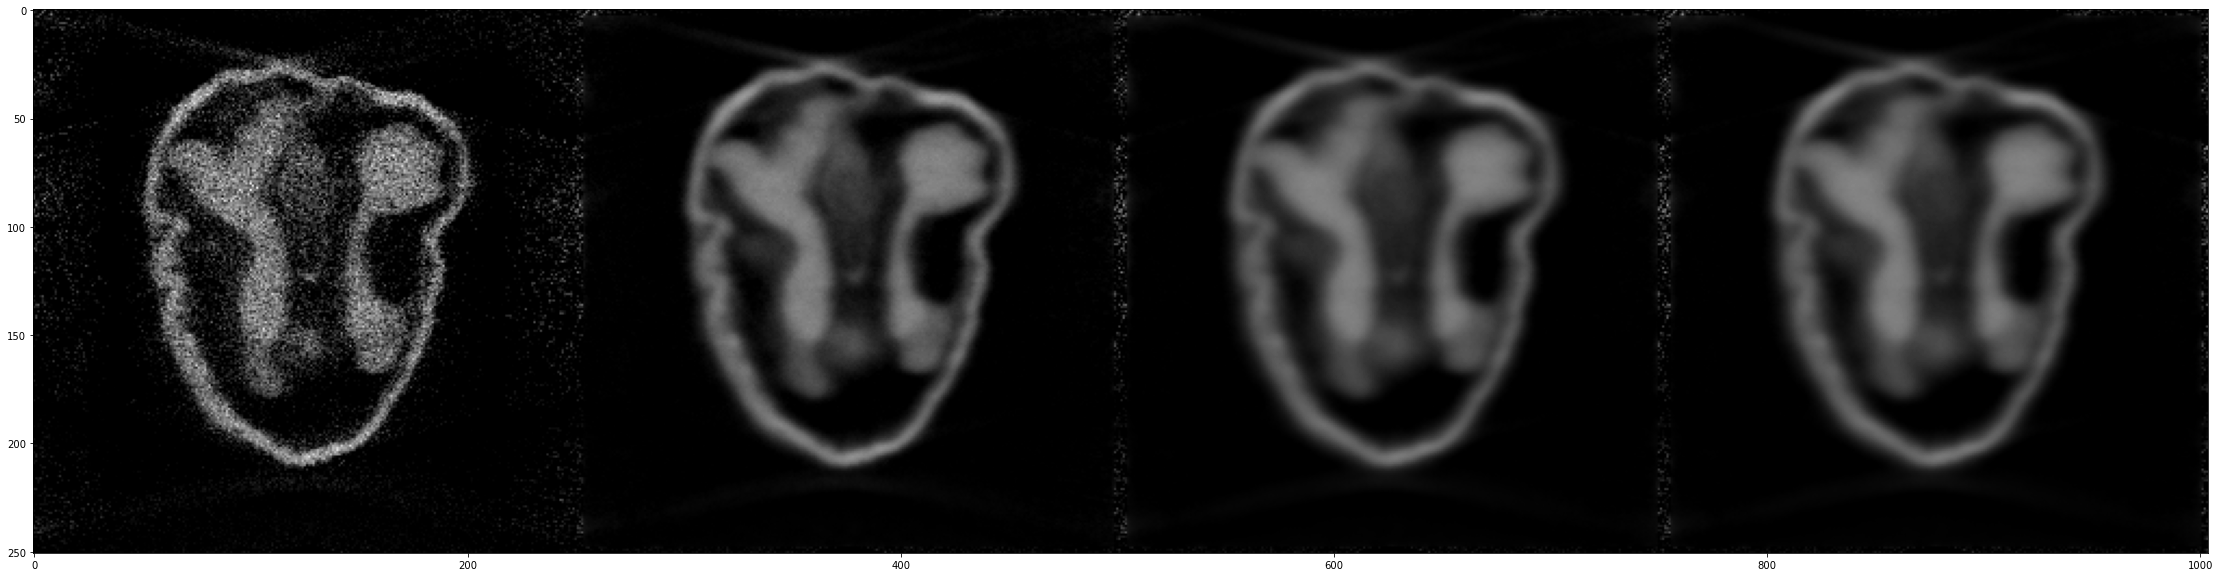

In [25]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/14_*')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[3])
    b = np.load(allfiles[0])
    c = np.load(allfiles[1])
    d = np.load(allfiles[2])

slice_index  = 140
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')
# np.random.seed(10)

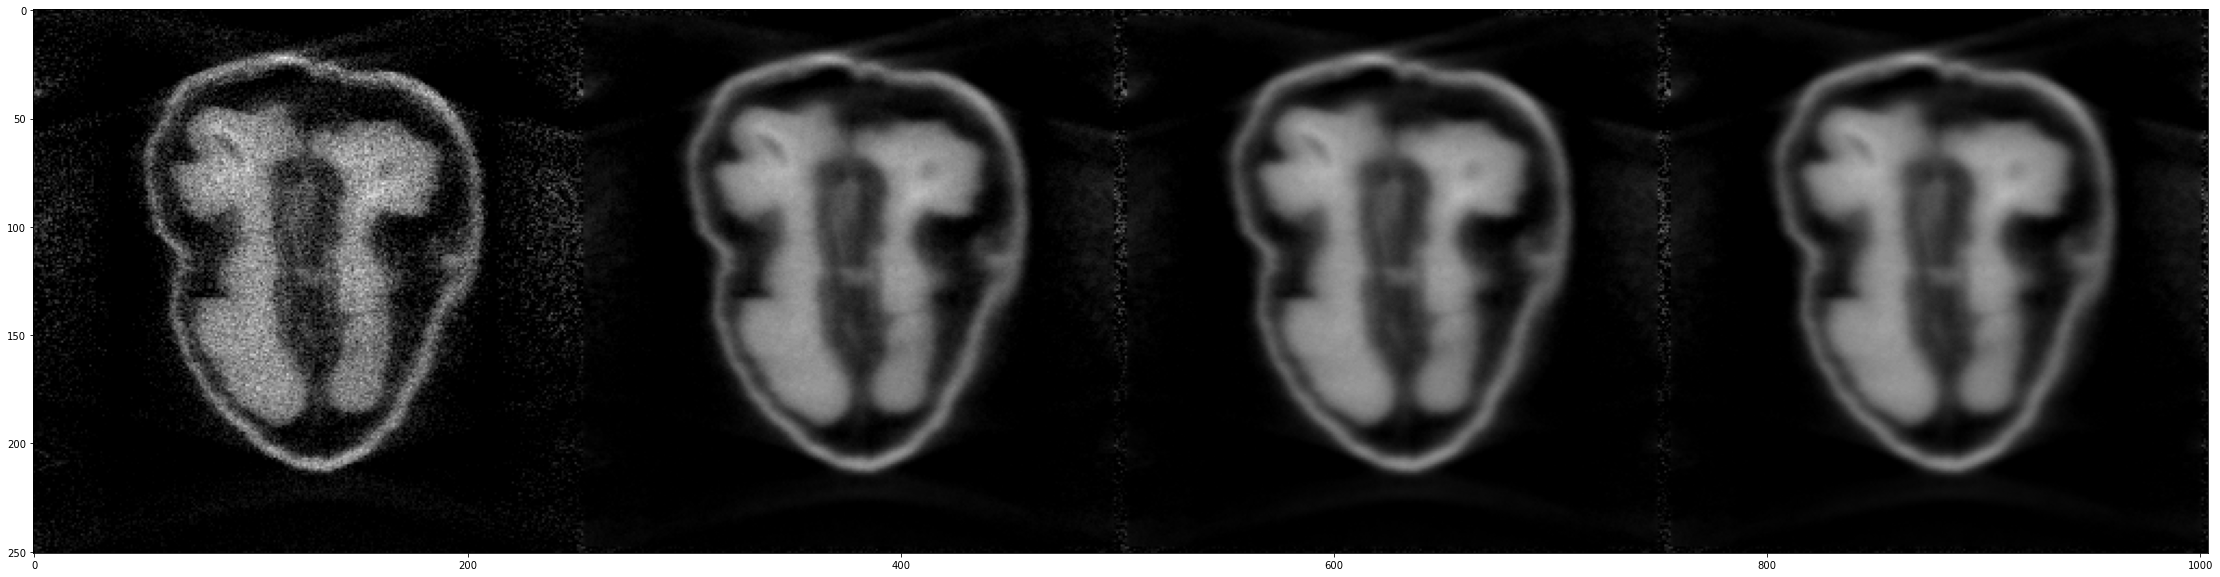

In [48]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/17_*')
    #for p in allfiles:
    #    print(p)

    a = np.load(allfiles[4])
    b = np.load(allfiles[6])
    c = np.load(allfiles[0])
    d = np.load(allfiles[2])

slice_index  = 150
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')
# np.random.seed(10)

/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0042_50.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0193_50.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0213_50.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0_50.npy


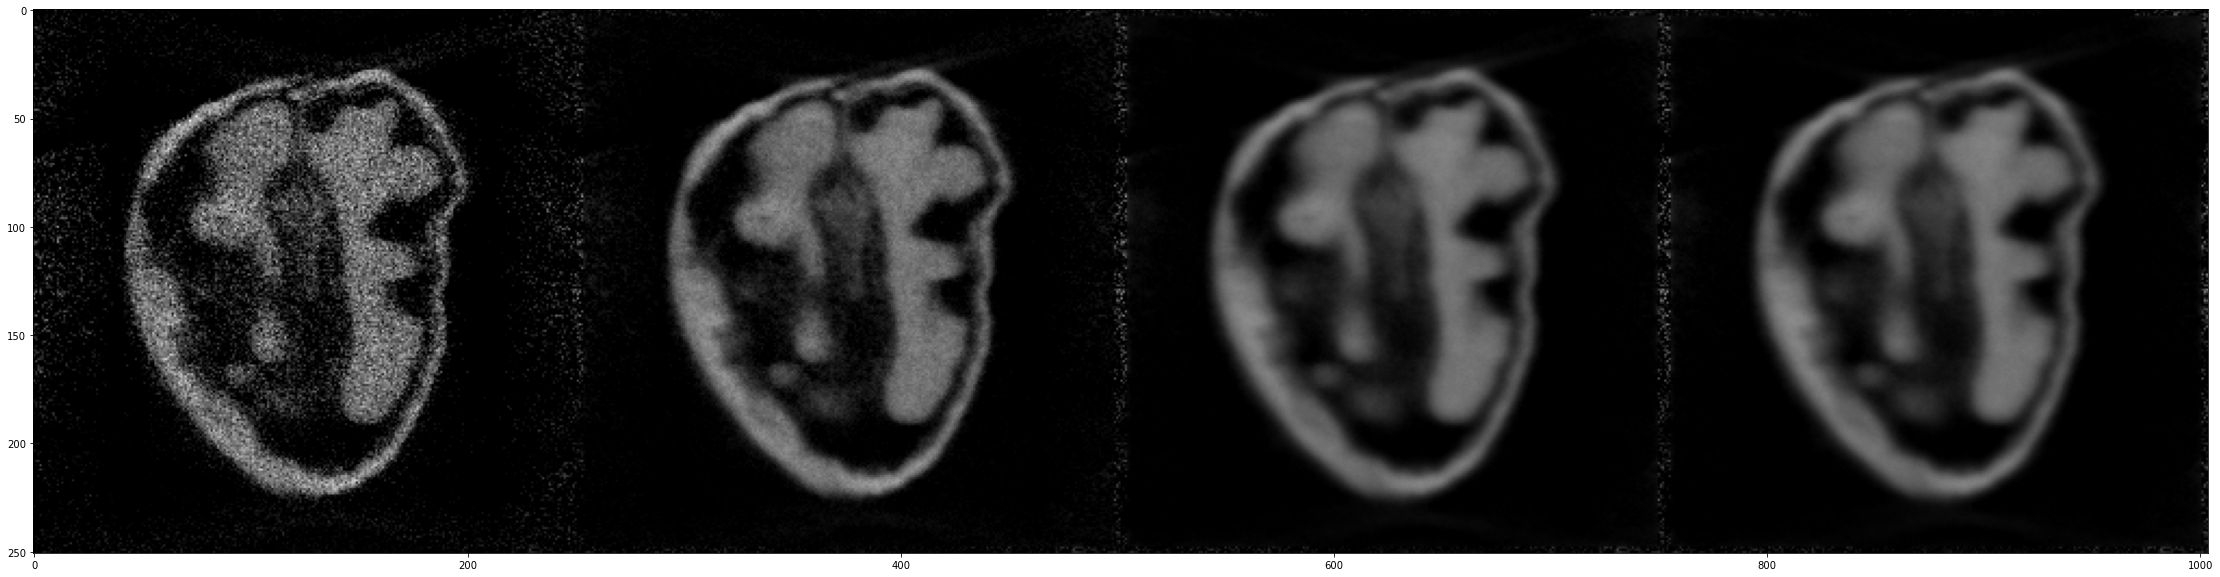

In [56]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/1_*_50.npy')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[3])
    b = np.load(allfiles[0])
    c = np.load(allfiles[1])
    d = np.load(allfiles[2])

slice_index  = 150
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')
# np.random.seed(10)

/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0384_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0076_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0135_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0253_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0425_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0_50_huber.npy


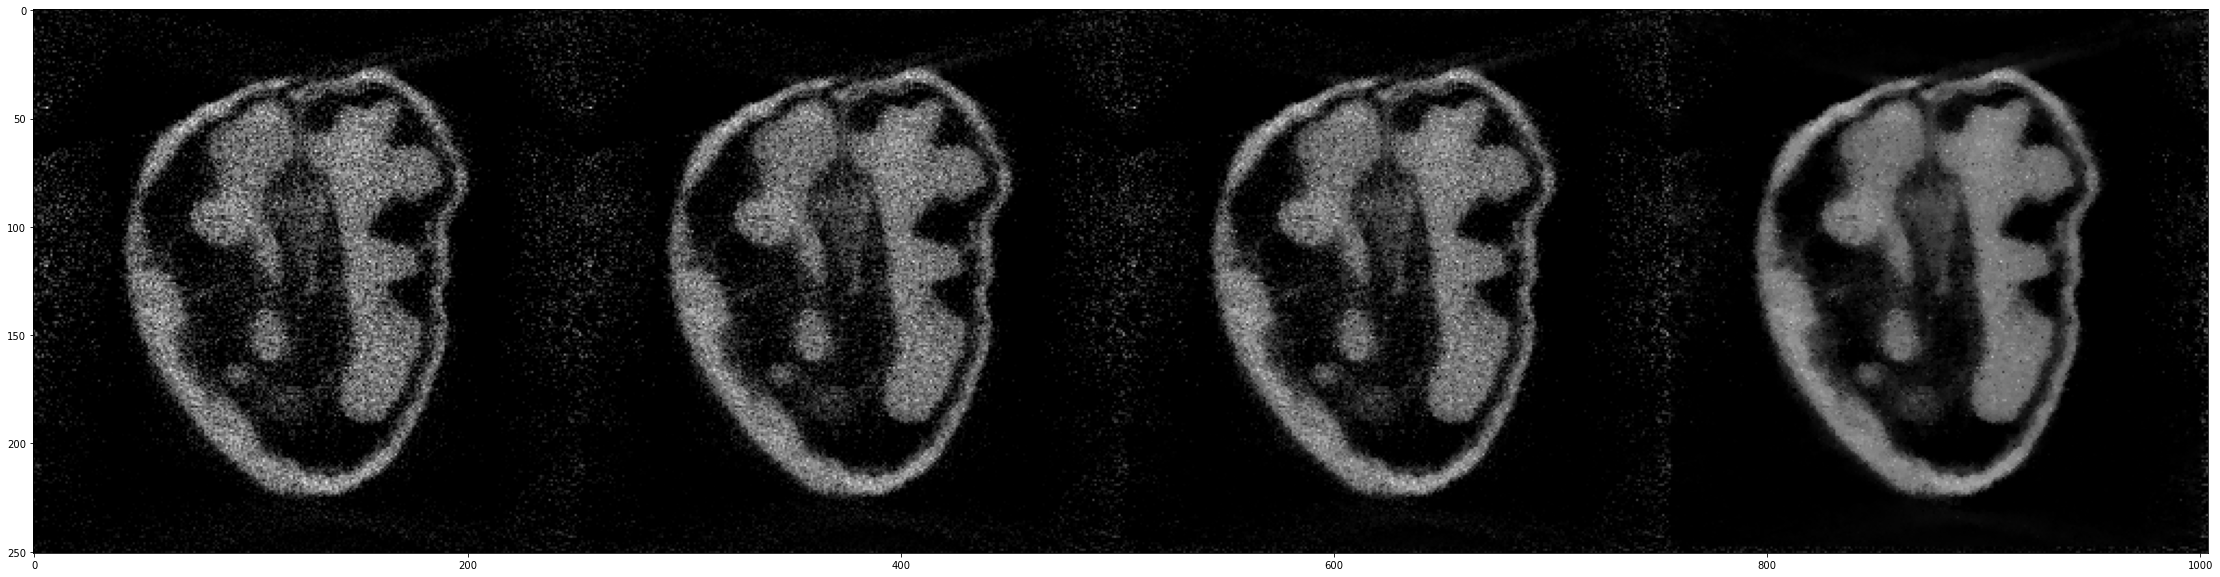

In [80]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/1_*_50_huber.npy')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[5])
    b = np.load(allfiles[1])
    c = np.load(allfiles[2])
    d = np.load(allfiles[0])

slice_index  = 150
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')
# np.random.seed(10)

/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0384_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0076_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0135_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0253_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0425_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0_50_huber.npy


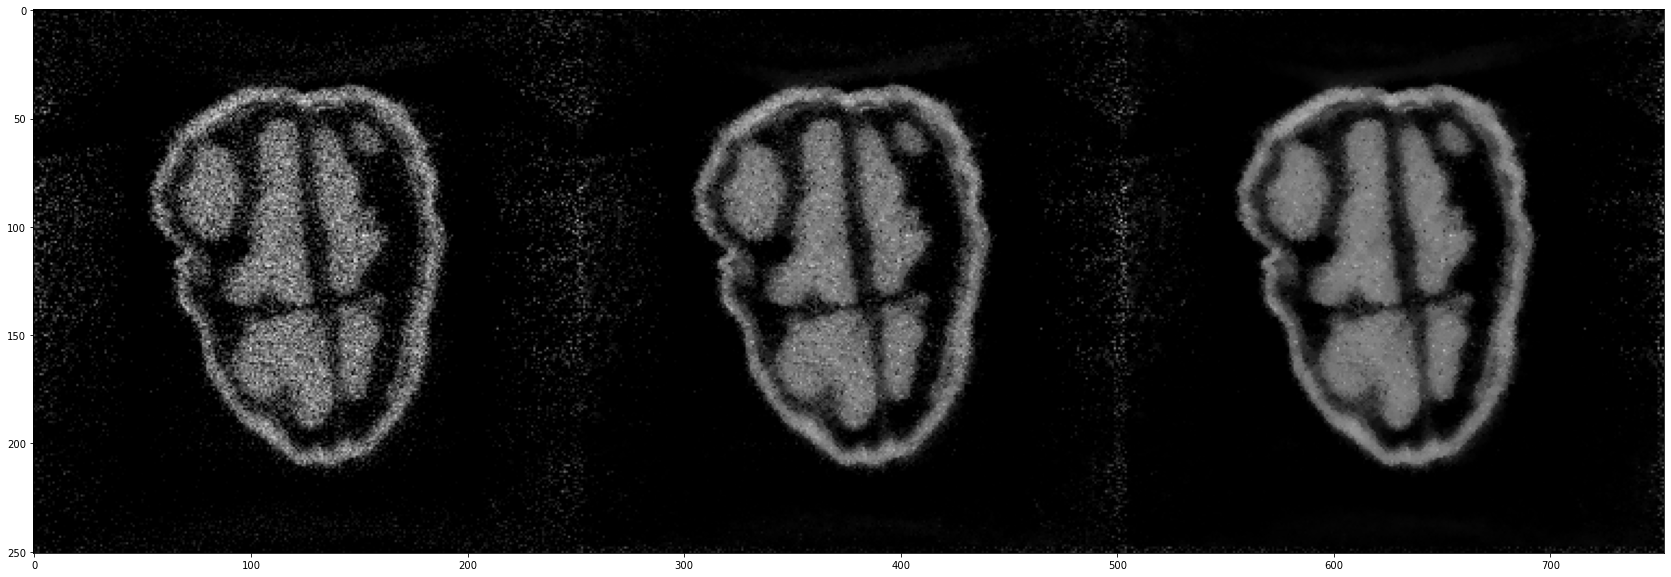

In [78]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/1_*_50_huber.npy')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[5])
    b = np.load(allfiles[1])
    c = np.load(allfiles[2])
    d = np.load(allfiles[3])
    e = np.load(allfiles[0])
    f = np.load(allfiles[4])

slice_index  = 170
plt.figure(figsize=(40,10))
#plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')

plt.imshow(np.concatenate([a[:, slice_index, :],  d[:, slice_index, :],  f[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')

/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0384_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0076_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0135_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0253_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0.0425_50_huber.npy
/media/yu-hao/WindowsData/WalnutDataRecon/1_0_50_huber.npy


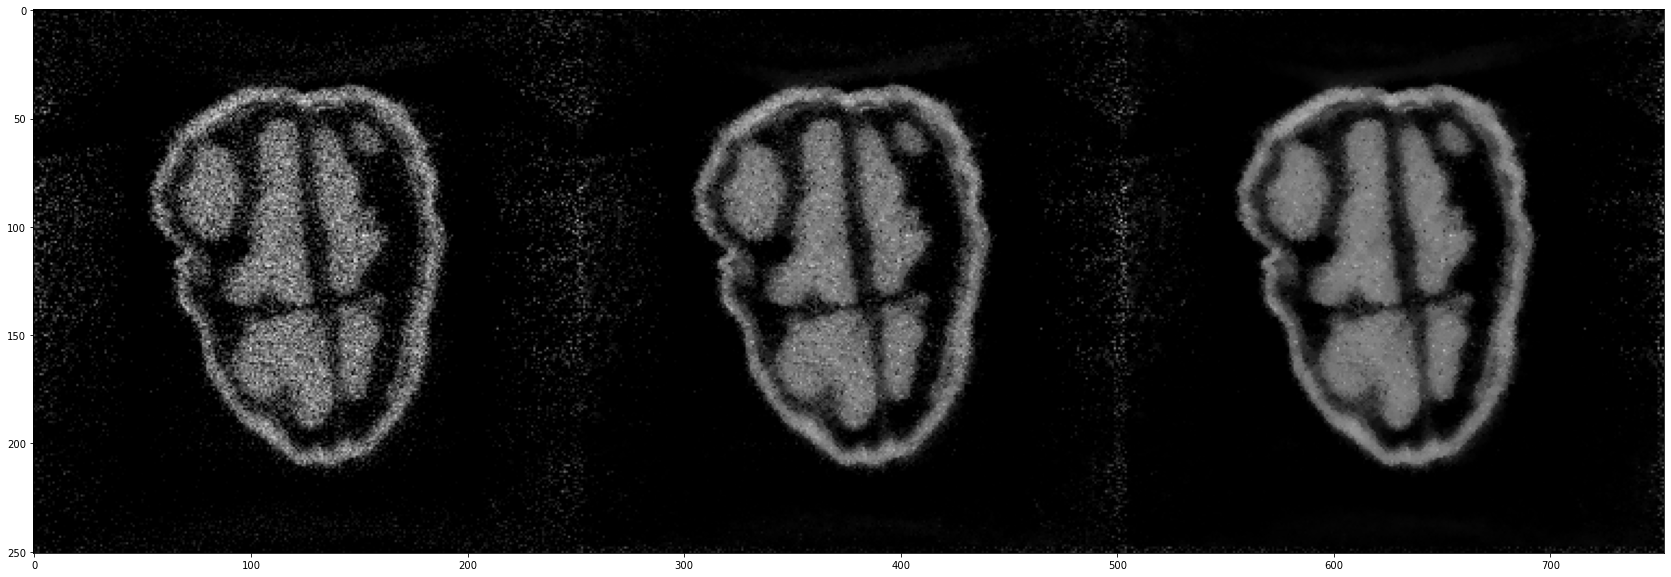

In [83]:
import numpy as np
import glob
import matplotlib.pyplot as plt

from skimage.filters import unsharp_mask, threshold_local, threshold_minimum


if 1:
    allfiles = glob.glob('/media/yu-hao/WindowsData/WalnutDataRecon/1_*_50_huber.npy')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[5])
    b = np.load(allfiles[1])
    c = np.load(allfiles[2])
    d = np.load(allfiles[3])
    e = np.load(allfiles[0])
    f = np.load(allfiles[4])

# slice_index  = 170
# temp            = a[:, slice_index, :]
# thresh_min      = threshold_minimum(temp)
# binary_adaptive = temp > thresh_min

# a[:, slice_index, :] = np.multiply(a[:, slice_index, :], binary_adaptive)
# b[:, slice_index, :] = np.multiply(b[:, slice_index, :], binary_adaptive)
# c[:, slice_index, :] = np.multiply(c[:, slice_index, :], binary_adaptive)
# d[:, slice_index, :] = np.multiply(d[:, slice_index, :], binary_adaptive)
# e[:, slice_index, :] = np.multiply(e[:, slice_index, :], binary_adaptive)
# f[:, slice_index, :] = np.multiply(f[:, slice_index, :], binary_adaptive)


plt.figure(figsize=(40,10))
#plt.imshow(np.concatenate([a[:, slice_index, :], b[:, slice_index, :], c[:, slice_index, :], d[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')

plt.imshow(np.concatenate([a[:, slice_index, :],  d[:, slice_index, :],  f[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')

(array([53960.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9041.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

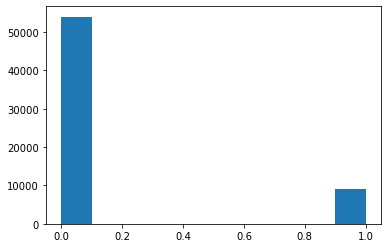

In [86]:
plt.hist(binary_adaptive.flatten().astype('float'))

In [ ]:
import numpy as np


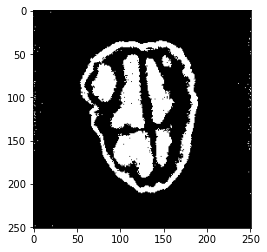

In [95]:
import scipy.ndimage as ndimage

slice_index  = 170
temp            = f[:, slice_index, :]
thresh_min      = threshold_minimum(temp)
binary_adaptive = temp > thresh_min

temp1 = ndimage.binary_fill_holes(binary_adaptive, structure=np.ones((50,50))).astype(int)

#a[:, slice_index, :] = np.multiply(a[:, slice_index, :], binary_adaptive)
plt.imshow(temp1, cmap='gray')

In [6]:
# if(torch.cuda.is_available()):
#     model_student.cuda()# rnn is your model 
    
#for m in model_student.parameters():
    #print(m.device)
    #hidden = hidden.cuda() 
    #target = target.cuda()

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

In [8]:
class UNetLstm(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetLstm, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
    
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        
        
       # print('x5:',x5.shape)
        
        xlst = x5.reshape([4,512,1024])

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
       # print('xlst',xlst.shape)  
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
    
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = ndarray((4,512,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
      #  print('h shape',h.shape)
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
       #     print('oo shape',oo.shape)
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        
      #  print('a shape:',a.shape)
        a = a.reshape([4,512,32,32])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
       # print('after x5 is ',x5.shape)
 
        
        
        x5 = self.lsgn1(x5)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

In [9]:
class AttnDecoderRNN_unet(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=512, bilinear=True):
        super(AttnDecoderRNN_unet, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_2 = nn.Linear(1536, self.max_length)
        
        self.attn_H = nn.Linear(512, 1024)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.gru = nn.GRU(1024,1024)
        
        self.out = nn.Linear(1024,1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsgn_h = nn.GroupNorm(128,512)
    
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        #print('h shape : ',h.shape)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        #print('hibilstm')
        #print(hidden_bilstm.shape)
    
     
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        
       # print('new:',hidden_bilinn.shape)
    
        hidden_bilinn = self.lsgn_h(hidden_bilinn)
        
#         print('embedded,hidden,cat')
#         print(embedded[0].shape)
#         print(hidden_bilinn.shape)
#         print(torch.cat((embedded[0], hidden_bilinn), 1).shape)
        
        
        attn_weights = F.softmax(self.attn_2(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
       # print('attn_weights : ')
        #print(attn_weights.shape)
        
        attn_weights  = self.lsgn_h(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
        

        output = torch.cat((embedded[0], attn_applied[0]), 1)

    
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        hidden_bi = self.attn_H(hidden_bi)
        
        
        output = F.relu(output)
        
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

In [12]:


def train_model(model, optimizer, criterion, trainx, trainy, augment=False):
    batch_size = 8
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=8):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array


#v1 = get_selected_lesion(valy, 300, 512*512)http://localhost:8080/notebooks/Inf-Net/Untitled%20(1).ipynb#

basepath  = '/home/ubuntu/Inf-Net/xx/'

train_ids      = np.load(basepath+'TRAIN.npy')
val_ids        = np.load(basepath+'VALIDATION.npy')
test_ids       = np.load(basepath+'TEST.npy')
unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')



train_ids_t = train_ids[:30]



trainx_l, trainy_l = read_training_data(train_ids_t)
valx, valy         = read_training_data(val_ids)
testx, testy       = read_training_data(test_ids)

#valx2,valy2 = read_training_data(val_ids[5:10])

#valx_img = sitk.GetImageFromArray(valx.astype('float32')[:, 0, :, :])


attn_decoder1 = AttnDecoderRNN(256, 256,dropout_p=0.1)

attn_decoder1.cuda()


# attn_decoder1 = AttnDecoderRNN_unet(1024,1024,dropout_p=0.1)

# attn_decoder1.cuda()



#sitk.WriteImage(valx_img, basepath+'CT-img.nii.gz')
#hidden = (nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda()))

model_student = UNetDoubleSmallGroupNormdifferent(1,1)
model_student.cuda()

model_sample = UNetLstm(1,1)
model_sample.cuda()



# model_student_2 = UNetDoubleSmallGroupNormdifferent(1,1)
# model_student_2.cuda()



optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001,weight_decay=1e-5)

#optimizer_student_2  = optim.Adam(model_student_2.parameters(), lr=0.0001,weight_decay=1e-5)

optimizer_sample = optim.Adam(model_sample.parameters(),lr=0.0001,weight_decay=1e-5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



optimizer_attn_w  = optim.Adam(attn_decoder1.parameters(), lr=0.0001,weight_decay=1e-5)


#scheduler = optim.ReduceLROnPlateau(optimizer_student, 'min')


criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

#criterion          = nn.BCEWithLogitsLoss()


val_loss_array   = []
train_loss_array = []


x_array (480, 1, 512, 512)
x_array (179, 1, 512, 512)
x_array (126, 1, 512, 512)


In [ ]:
# model_sample.load_state_dict(torch.load("/home/ubuntu/Inf-Net/sample-lstm-bs4-nocnn.pt"))
# model_sample.eval()

for epoch in range(300):

    
    train_loss = train_model(model_student, optimizer_student, criterion,trainx_l,trainy_l, augment=False)

        
    if(epoch%1==0):
        test_50 = evaluate_result(model_student,testx,testy)
        val_dice_50   = evaluate_result(model_student, valx, valy)
        print(epoch,'done and the testing dice and val dice:',np.mean(test_50),np.mean(val_dice_50))
        
        torch.save(model_student.state_dict(),"/home/ubuntu/Inf-Net/student-lstm-bs8-nocnn.pt")

        
    

print('done')


In [ ]:
# for i in range(len(list(attn_decoder1.parameters()))):
    #print(list(attn_decoder1.parameters())[i].size())

In [ ]:
# model_teacher.load_state_dict(torch.load("/home/ubuntu/Inf-Net/teacher-lstm.pt"))
# model_teacher.eval()
# for epoch in range(301):

#     print(epoch)
#     #print(hidden)
#     #print(attn_weights)
    
#     train_loss = train_model_attn(attn_decoder1,optimizer_attn_w,model_teacher ,criterion,trainx_l,trainy_l, augment=False)

        
#     if(epoch%10==0):
#         torch.save(attn_decoder1.state_dict(),"/home/ubuntu/Inf-Net/attndecoder-lstm.pt")
#         test_50 = evaluate_result_dec(attn_decoder1,model_teacher,testx,testy)
#         val_dice_50   = evaluate_result_dec(attn_decoder1,model_teacher ,valx, valy)
#         print(epoch,'done and the testing dice and val dice:',np.mean(test_50),np.mean(val_dice_50))

        
    

print('done')

In [ ]:
model_student.load_state_dict(torch.load("/home/ubuntu/Inf-Net/student-GN-lstm-bs4-nocnn.pt"))
model_student.eval()

test_50 = evaluate_result(model_student,testx,testy)
val_dice_50   = evaluate_result(model_student, valx, valy)
print('done and the testing dice and val dice:',np.mean(test_50),np.mean(val_dice_50))



In [ ]:
x = val_ids[:5] 
y = test_ids
lists = np.concatenate((x,y),axis=0)
testx2,testy2 = read_training_data(lists)

In [ ]:
model_student_2.load_state_dict(torch.load("/home/ubuntu/Inf-Net/student-2-lstm-mix.pt"))
model_student_2.eval()

In [ ]:
def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    #print(len(X))
   # print(r[1][0])
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        #print(i)
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

In [ ]:
# = train_dice_array
# for ele,i in enumerate(a):
#     print("\n",i," ",ele)

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    #c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
   # plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    #plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    print("saved")
    plt.close()
    plt.clf()
    
    return    
    
plot_figure(model_save_name='ra')

    

In [ ]:
step_size = 10
train_dice_array = []

train_dice_array_2 = []

val_dice_array = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for epoch in range(300):
    temp_index                 = epoch%(int(len(unlabelled_ids)/step_size))
    #print(temp_index)
    
    p = np.random.randint(78)
    trainx1, trainx1_lungmask  = read_training_data_unlabelled(unlabelled_ids[p*step_size:p*step_size+step_size])
    trainy1,trainx1                = get_prediction(model_student, trainx1)
    

    
    #print('after predciton : trainy1',trainy1.shape)
    #print('after prediction : trainx1',trainx1.shape)
    
    train_ids_t = []
    for i in range(10):
        t = train_ids[np.random.randint(29)]
        train_ids_t.append(t)

    trainx_l, trainy_l = read_training_data(train_ids_t)
    train_x = np.concatenate([trainx_l, trainx1])
    train_y = np.concatenate([trainy_l, trainy1])
    
    #print('after concatenation',train_x.shape,train_y.shape)
    train_x, train_y = sort_data(train_x, train_y)

    
    train_loss = train_model(model_student_2, optimizer_student_2, criterion, train_x, train_y)
    
    train_dice = evaluate_result(model_student_2, testx, testy)
    #train_dice_2 = evaluate_result(model_student_2, testx2, testy2)
    val_dice   = evaluate_result(model_student_2, valx, valy)
    
#     # Update teacher weights
#     if np.mean(val_dice) > val_dice_t:
#         print(epoch, ' Updating Teacher Weights')
#         torch.save(model_student.state_dict(), "temp.pt")
#         torch.save(model_student.state_dict(), basepath_models+model_save_name+".pt")
#         p1         = torch.load('temp.pt')
        
#         model_teacher.load_state_dict(p1)
 #   val_dice_t = np.mean(val_dice)
    
    train_dice_array.append(np.mean(train_dice))
    
   # train_dice_array_2.append(np.mean(train_dice_2))
    val_dice_array.append(np.mean(val_dice))
    
    print("Step %d  Train Dice %.5f  Val Dice %.5f " % (epoch, np.mean(train_dice), np.mean(val_dice)))
    

In [ ]:
torch.save(model_student_2.state_dict(),"/home/ubuntu/Inf-Net/student-2-lstm-mix.pt")




In [ ]:


# print(lists)







val_dice_2   = evaluate_result(model_student_2, valx, valy)

#print(np.mean(train_dice_2),val_dice_2)


for i in range(172):
      print(i,train_dice_array[i],val_dice_array[i])
    
    
    
print(max(train_dice_array),max(val_dice_array))

# max(val_dice_array)